○ Detección de bordes.

# Parcialito I -  Mejoramiento de Imágenes - Brisa Rojas (60535)
---

Primero vamos a importar las librerías necesarias para trabajar.

In [19]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
from scipy import signal

También vamos a cargar la imagen que vamos a trabajar desde su `path`.

In [20]:
path = './img12.png'
img12 = cv2.imread(path,0)

Vamos a ver con que imagen vamos a trabajar.

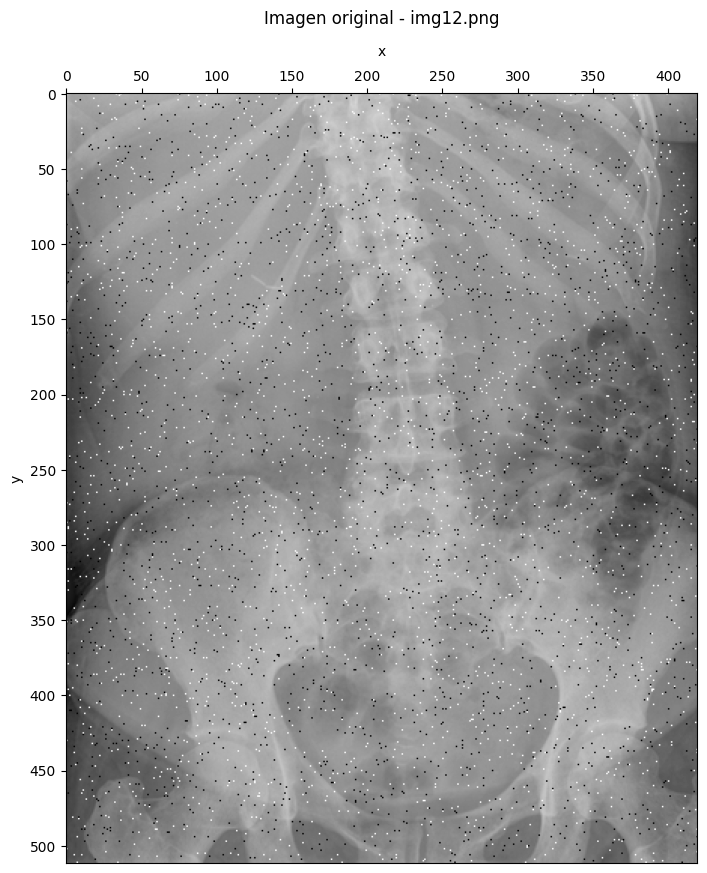

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img12, cmap='gray')

# Acomodamos el título y los ejes
ax.set_title('Imagen original - img12.png', pad = 50)
ax.set_xlabel('x')
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad = 10
ax.xaxis.set_ticks_position('top')
ax.set_ylabel('y')
y = img12.shape[0]
ax.set_yticks(np.arange(0, y, 50))


# Mostramos la imagen
plt.show()

# Imagen a mejorar: `img12.png`
La imagen es una radiografía de la parte media y baja de la columna vertebral y la pelvis.

## Qué es una radiografía?
Una radiografía es una imagen médica obtenida mediante el uso de **radiación ionizante** para crear imágenes del interior del cuerpo humano. Implica la **emisión de rayos X** (radiación electromagnética de alta energía) a través del cuerpo, interaccionando con el mismo mediante efecto fotoeléctrico o efecto Compton, y que **disminuyen su intensidad en distintas proporciones por los distintos tejidos debido a sus densidades**, lo que permite crear una **imagen bidimensional** en una placa o detector digital que se ubica detrás del paciente (y de la zona a irradiar).

Las radiografías se utilizan para diagnosticar enfermedades, lesiones y fracturas. También se utilizan para detectar anomalías en el desarrollo de los huesos y en el crecimiento de los niños.

Dentro de las cosas que podríamos mencionar de la imagen se encuentran
- Ruido del tipo sal y pimienta
- Poco contraste: todo se ve en tonos grises claros - blanco
- Bordes no muy bien definidos
- Se observa una mancha gris oscura hacia el costado derecho de la imagen que parecen ser gases dentro del intestino (recordando que los gases se ven negros en una radiografía), también hay manchas en otras zonas del intestino pero no tan notorias como la mencionada.

## Objetivos a mejorar
 
Debido a la zona de la radiografía, nos da a pensar que lo que podría querer un médico es observar la columna en su zona media-baja, para diagnosticar si el paciente tiene o no escoliosis, por ejemplo.
Entonces se puede mejorar el contraste para que esto se pueda observar bien, definir los bordes por el mismo motivo y quitar el ruido para mejorar la imagen en general. También se podría quitar la mancha de gases del intestino.

Para lograr esta mejora se van a aplicar las siguientes técnicas de procesamiento de imagen:

- *Ecualización del histograma*: Esta técnica se utilizará para mejorar el contraste de la imagen. La ecualización del histograma redistribuye los valores de los píxeles para que cubran todo el rango dinámico de la imagen. Como resultado, las áreas más oscuras se vuelven más oscuras y las áreas más claras se vuelven más claras, lo que mejora el contraste general de la imagen.

- *Filtro de mediana*: Este es un filtro no lineal que se aplica a una imagen para reducir el ruido del tipo sal y pimienta eliminando los valores extremos de los píxeles en una vecindad. En otras palabras, se reemplaza el valor de cada píxel por el valor mediano de los píxeles en su vecindad.

- Detección de bordes: Esta técnica se utilizara para mejorar la definición de los bordes en la imagen. La detección de bordes se refiere a la identificación de las transiciones abruptas en la intensidad de la imagen. Se utilizó un filtro de Sobel para identificar los bordes en la imagen. El filtro de Sobel es un operador de gradiente que resalta los bordes verticales y horizontales en una imagen. El filtro de Sobel se compone de dos filtros separables, uno para cada dirección. El filtro de Sobel horizontal se utiliza para detectar bordes verticales y el filtro de Sobel vertical se utiliza para detectar bordes horizontales.

# Procesamiento



## Filtro de mediana

Primero, se filtrará para quitar el ruido sal y pimienta. Para esto, definimos 2 funciones: `filtroMediana` y `zeroPadding` que funciona como auxiliar para la primera.


In [22]:
def zeroPadding(img: np.ndarray, n: int) -> np.ndarray:
    '''
    Función que agrega ceros a una imagen en su borde
    Parámetros: 
        img: imagen de entrada
        n: número de filas a agregar en cada lado ()
    ''' 
    #crear imagen de ceros
    imgPad = np.zeros((img.shape[0]+2*n, img.shape[1]+2*n), dtype=np.uint8) 
    # Tiene n filas y n columnas de ceros  extra en cada lado
    #copiar imagen original en el centro de la imagen de ceros
    imgPad[n:img.shape[0]+n, n:img.shape[1]+n] = img
    return imgPad

In [23]:
def filtroMediana(img: np.ndarray, n: int) -> np.ndarray:
    '''
    Función que realiza el filtro de mediana sobre una imagen
    para eliminar el ruido sal y pimienta
    Parámetros: 
        img: imagen de entrada  
        n: dimensiones del kernel (filas y columnas)
    '''
    if n%2 == 0 or n == 0:
        # el kernel debe ser impar en sus dimensiones y ser no nulo
        print("El tamaño del kernel debe ser impar y mayor a 0")
        return
    

    #crear imagen de salida
    imgFilt = np.zeros((img.shape[0], img.shape[1]))

    #crear copia de la imagen de original
    corr = int((n-1)/2)
    imgCopy = np.copy(img)
    imgCopy = zeroPadding(imgCopy, corr)

    #recorrer la imagen copia
    for f in range(corr, img.shape[0]+ corr): 
        for c in range(corr, img.shape[1]+ corr):
            #crear el kernel con los valores de la imagen copia
            kernel = imgCopy[f-corr:f+corr+1, c-corr:c+corr+1]
            #ordenar los valores del kernel
            kernel = np.sort(kernel, axis=None)
            #agregar el valor del pixel central del kernel ordenado a la imagen de salida
            imgFilt[f-corr, c-corr] = kernel[int((n**2)/2)]

    '''
        Explicacion del bloque de for:
        f y c recorren la imagen original
        corr es la cantidad de filas/columnas que se agregan en cada lado de la imagen copia
        f-corr:f+corr+1 y c-corr:c+corr+1 recorren la imagen copia, donde el -corr es para que no se salga de los limites
        de la imagen copia, y el +1 es porque el indice de python no incluye el ultimo valor

        Creamos el kernel con los valores de la imagen copia, lo ordenamos después de aplanarlo con axis=None
        y como la len del kernel es n*n, el valor del pixel central es el de la posicion n*n/2 (truncado)

    '''

    return imgFilt

Vamos a ver como queda la imagen luego de aplicar el filtro de mediana. En principio, se prueba con un kernel de 3x3: si esto no quita el ruido, se prueba con un kernel de mayores dimensiones.

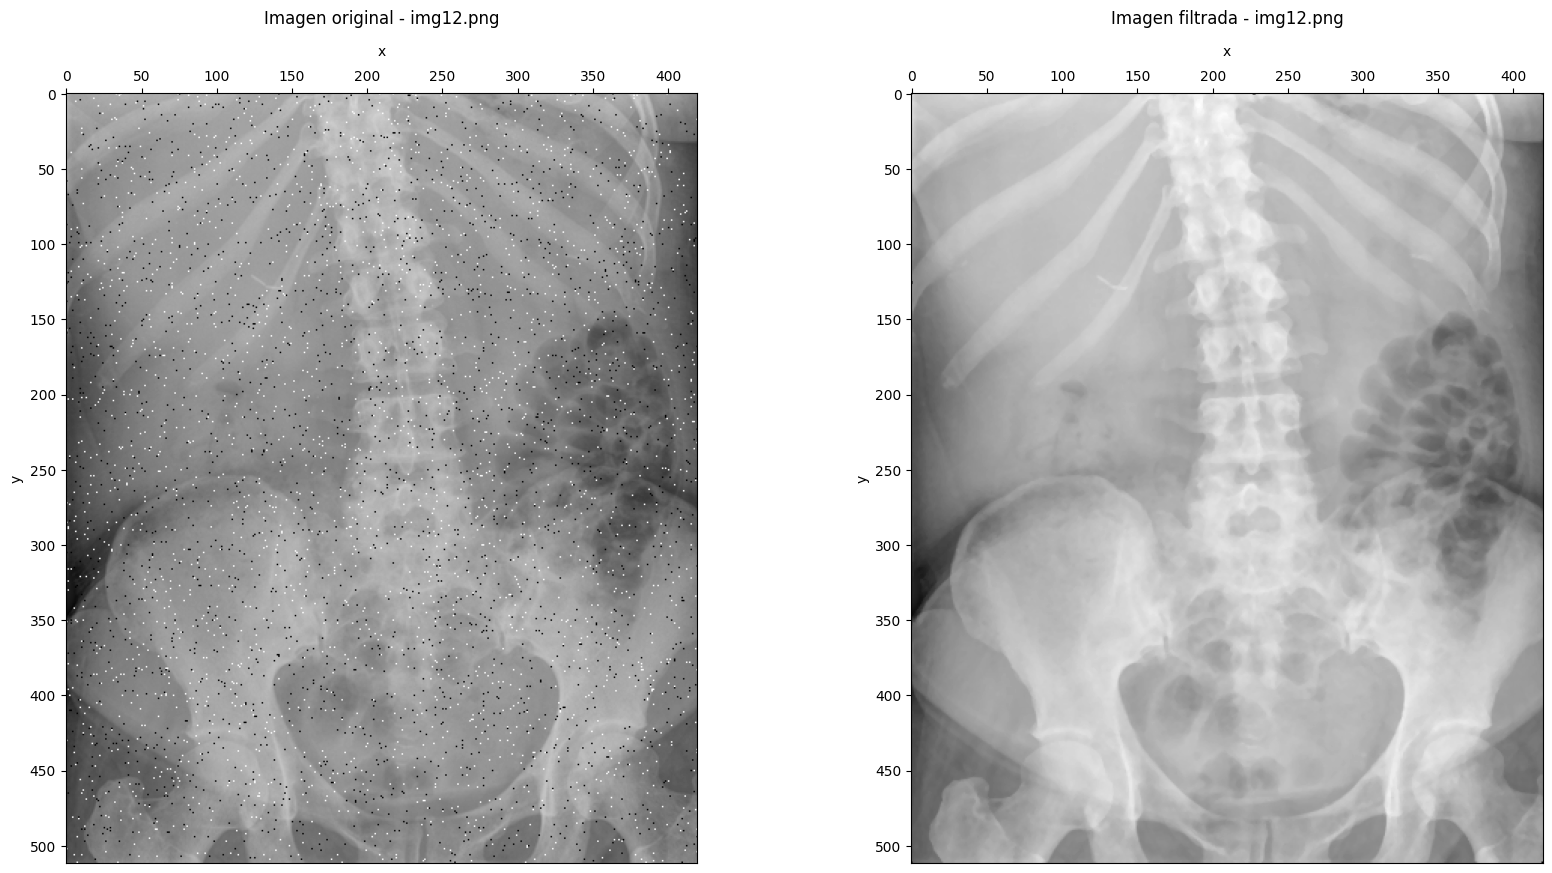

In [24]:
# Aplicamos el filtro de mediana a la img12
img12Mejorada = filtroMediana(img12, 3) # kernel de 3x3

# Mostramos la imagen original y la imagen filtrada
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img12, cmap='gray')
ax[1].imshow(img12Mejorada, cmap='gray')
# Acomodamos el título y los ejes de ambas imagenes
ax[0].set_title('Imagen original - img12.png', pad = 50)
ax[0].set_xlabel('x')
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.labelpad = 10
ax[0].xaxis.set_ticks_position('top')
ax[0].set_ylabel('y')
y = img12.shape[0]
ax[0].set_yticks(np.arange(0, y, 50))
ax[1].set_title('Imagen filtrada - img12.png', pad = 50)
ax[1].set_xlabel('x')
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.labelpad = 10
ax[1].xaxis.set_ticks_position('top')
ax[1].set_ylabel('y')
y = img12.shape[0]
ax[1].set_yticks(np.arange(0, y, 50))
plt.show()

Se observa que con el kernel de 3x3 se logra quitar el ruido sal y pimienta. Si se prueba con un kernel de 5x5, se observa que se quita el ruido pero también se borran aún más los bordes de la imagen, por lo que se decide quedarse con el kernel de 3x3.

Otra observación a realizar es que sin el ruido, se puede ver que la mancha anteriormente mencionada es de mayor tamaño que el observado en la imagen original.

## Contraste de la imagen  

Si bien a simple vista podemos ver el bajo contraste de la imagen original, vamos a ver como se ve el histograma de la imagen original y luego de ecualizar el histograma para ver el efecto de la ecualización.

Para esto definimos una función de histograma.



In [25]:
def histograma(img :np.ndarray, verbose=False, normalized=False, plot=True, grid=False, accumulated=False) -> np.ndarray or None :
    '''
    Función que calcula el histograma de una imagen
    Parámetros: 
        img: imagen de entrada
        verbose: si es True devuelve el arreglo de valores de frecuencia
        normalized: si es True devuelve el histograma normalizado respecto al número de píxeles totales
        plot: si es True muestra el histograma
        grid: si es True muestra las líneas de la grilla
        accumulated: si es True muestra el histograma acumulado y normalizado sobre el histograma
    ''' 

    histX = np.arange(0, 256, 1)
    #crear array de numpy de 256 posiciones [0,255]
    histY = np.zeros(256)
    #recorrer la imagen
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #sumar 1 al valor del histograma correspondiente al valor de la imagen
            index = int(img[i,j]) #  por cualquier cosa que no sea un entero (ej: 1.0, 0.0, 255.0)
            histY[index] += 1

    if normalized:
        histY = histY / (img.shape[0] * img.shape[1]) #normalizar respecto al número de píxeles totales

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

        if grid:
            ax.grid(True)

        # Mostramos el histograma
        ax.bar(histX,histY, width=1.4, color='xkcd:sky blue', capstyle='butt', edgecolor='black', linewidth=0.2)
        ax.set_title('Histograma de intensidades de gris', pad = 10)
        ax.set_xlabel('Intensidad de gris')
        ax.set_xlim(0, 255)
        if normalized:
            ax.set_ylabel('Frecuencia relativa de aparición del tono de gris')
            # agregar un pad a la etiqueta del eje y para que no se solape con el valor de la barra
        else:
            ax.set_ylabel('Frecuencia de aparición del tono de gris')
        ax.yaxis.set_label_position("left")
        


        if accumulated:
            accHistY = np.zeros(256) #array de numpy de 256 posiciones [0,255] para los valores posibles de intensidad de gris
            accHistY[0] = histY[0] #el primer valor del histograma acumulado es el primer valor del histograma
            for i in range(1, 256): 
                accHistY[i] = accHistY[i-1] + histY[i] # valores acumulados = valores anteriores + valor actual
            
            accHistY = accHistY / (img.shape[0] * img.shape[1])  #normalizamos el histograma acumulado

            # create a second y-axis on the right side of the plot and plot the accumulated histogram 
            ax2 = ax.twinx()
            ax2.plot(histX, accHistY, color='xkcd:greyish purple', linewidth=2)
            ax2.set_ylim(0, 1) #seteamos el rango de valores del eje y del histograma acumulado
            ax2.set_ylabel("Frecuencia normalizada de aparición acumulada")
            ax2.yaxis.set_label_position("right")
            ax2.yaxis.tick_right()
            ax2.legend(['Histograma acumulado'], loc='upper left')

        plt.show()
    
    if verbose:
        return histY
    '''
        Se devuelve histY por si se quiere luego analizar con otra función
    '''


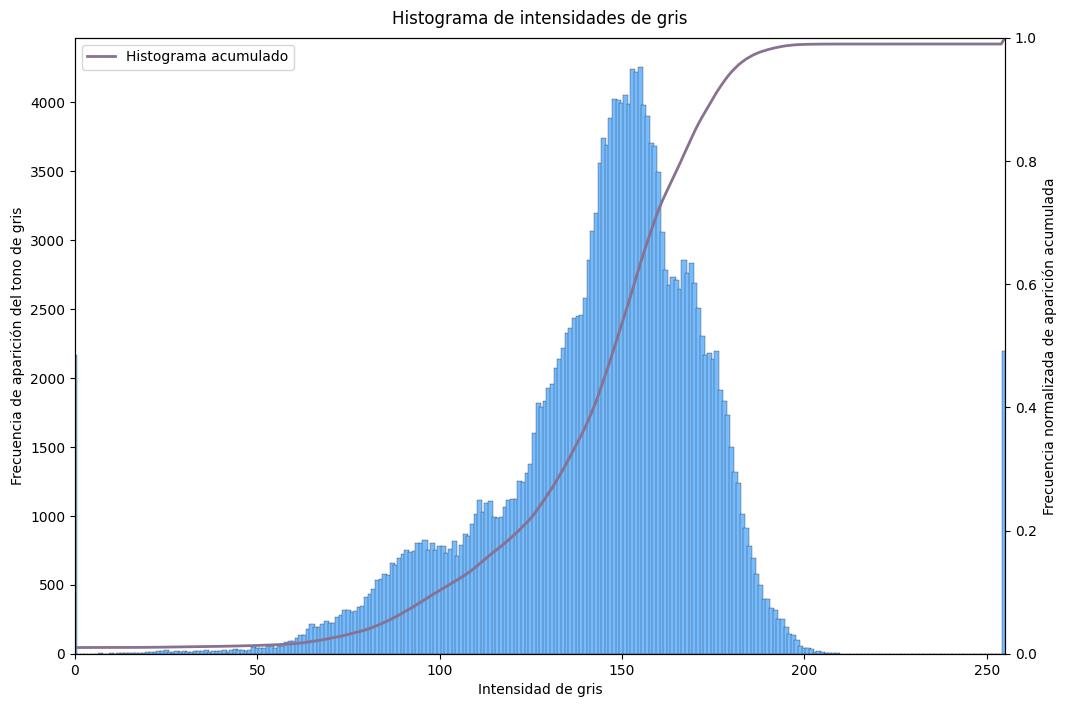

In [26]:
hist = histograma(img12, accumulated=True)

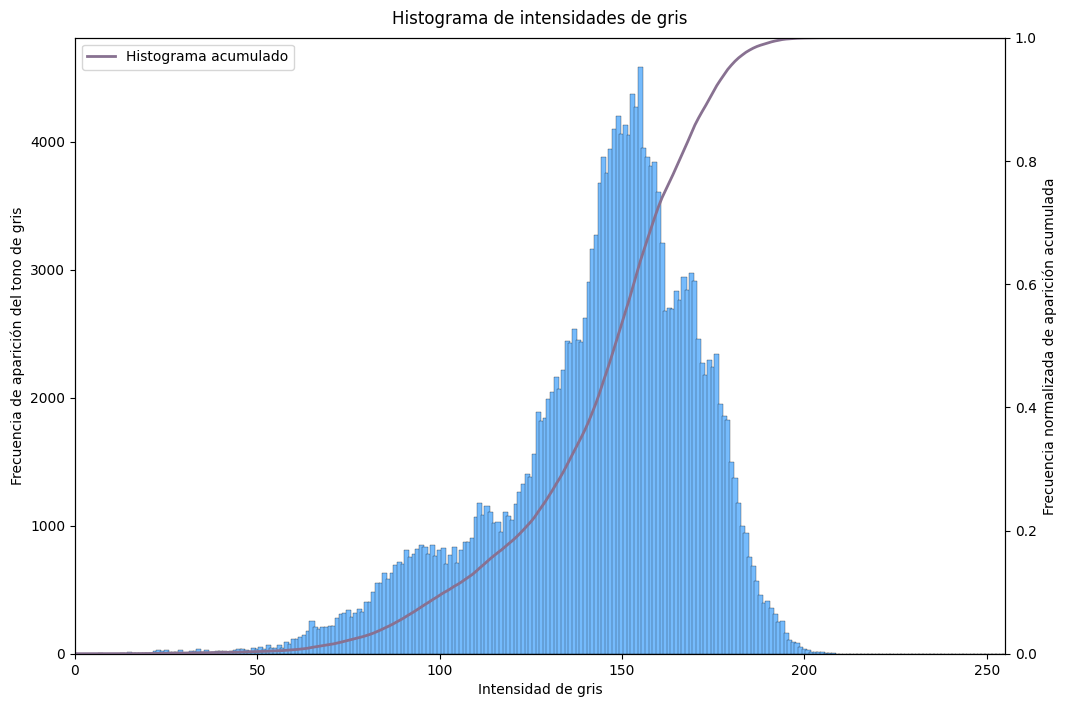

In [27]:
histMejorada = histograma(img12Mejorada, accumulated=True)

Como vemos, el histograma de la imagen original tiene una distribución muy concentrada en los valores de grises medios/altos, lo que hace que la imagen se vea muy clara. Se notan también los 'picos' en los valores 0 y 255, es decir negro y blanco que corresponden a los pixeles de ruido sal y pimienta.

En la imagen mejorada con el filtro de mediana podemos ver los grises se mantienen pero que los picos en o y 255 no se encuentran: es decir, es otra forma de comprobar (además de la visual) que el filtro funciona. Otra cosa a mencionar es que a causa de la falta de valores en 0 y 255 se puede ver que el histograma acumulado sube más lento en principio, pero llega a 1 mucho más rápido (aprox en 210).

Ahora vamos a ecualizar la imagen para aprovechar mejor el rango dinámico de trabajo.

In [28]:
def ecualizar(img:np.ndarray) -> np.ndarray:
    '''
    Función que ecualiza una imagen de entrada
    Parámetros:
        img: imagen de entrada numpy.ndarray
    '''
    hist = histograma(img, normalized=True, plot=False, verbose=True) #histograma normalizado

    CDF = np.zeros(256) # CDF : cumulative distribution function // histograma acumulado
    CDF[0] = hist[0]
    for i in range(1, 256):
        CDF[i] = CDF[i-1] + hist[i] # valores acumulados = valores anteriores + valor actual
    CDF *=  255 # llevamos los valores al rango [0,255]
    
    imgEcualizada = np.zeros(img.shape) 
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            imgEcualizada[i,j] = CDF[int(img[i,j])]
            
    return imgEcualizada

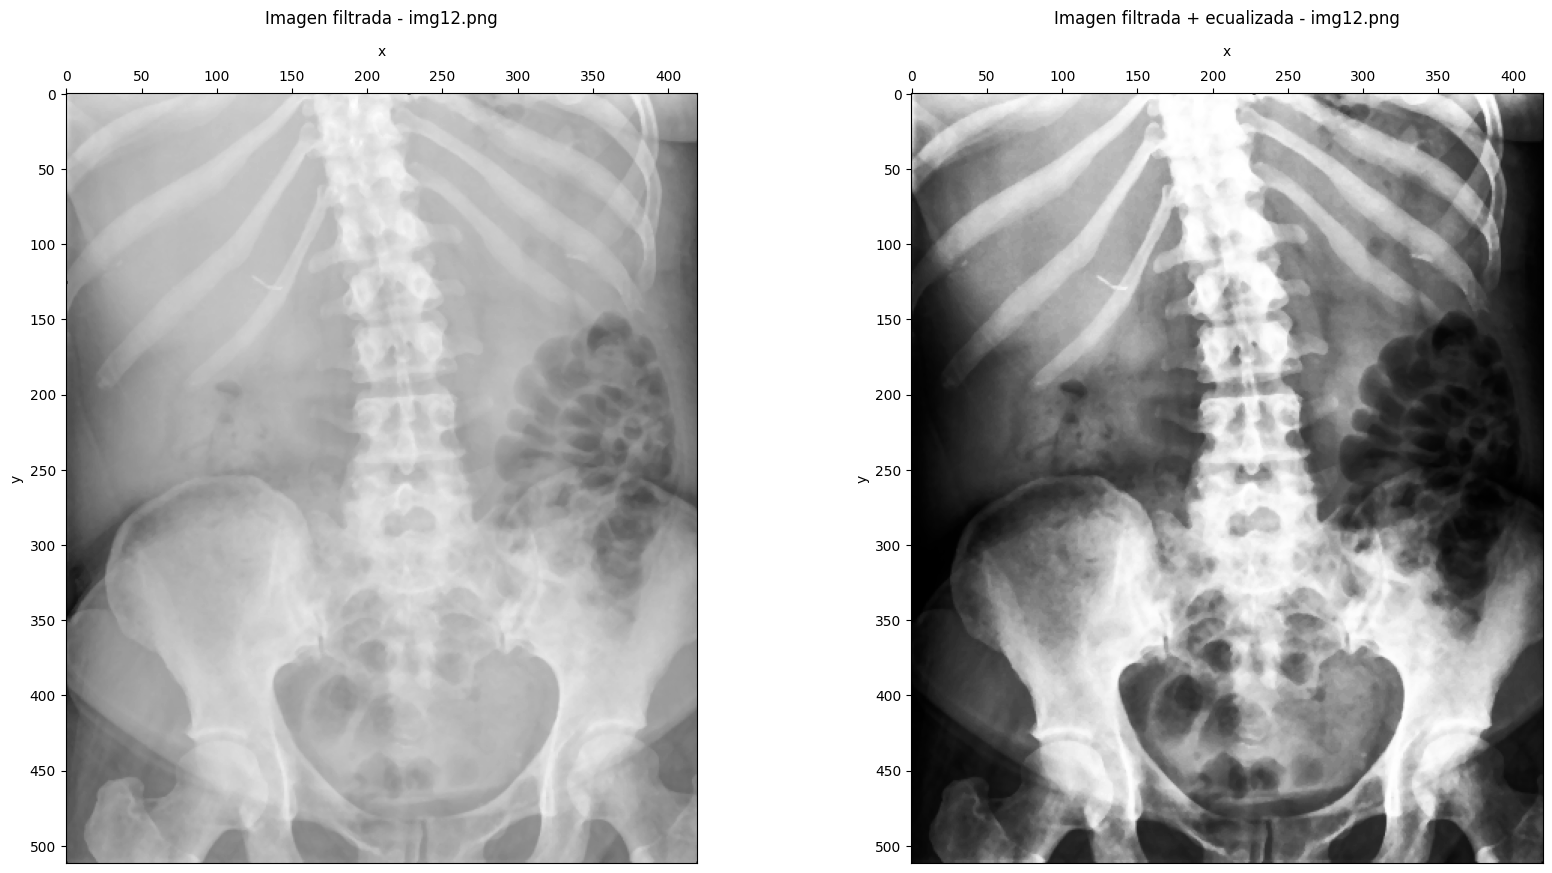

In [29]:
img12MejoradaEc = ecualizar(img12Mejorada)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img12Mejorada, cmap='gray')
ax[1].imshow(img12MejoradaEc, cmap='gray')
# Acomodamos el título y los ejes de ambas imagenes
ax[0].set_title('Imagen filtrada - img12.png', pad = 50)
ax[0].set_xlabel('x')
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.labelpad = 10
ax[0].xaxis.set_ticks_position('top')
ax[0].set_ylabel('y')
y = img12.shape[0]
ax[0].set_yticks(np.arange(0, y, 50))
ax[1].set_title('Imagen filtrada + ecualizada - img12.png', pad = 50)
ax[1].set_xlabel('x')
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.labelpad = 10
ax[1].xaxis.set_ticks_position('top')
ax[1].set_ylabel('y')
y = img12.shape[0]
ax[1].set_yticks(np.arange(0, y, 50))
plt.show()


Después de aplicar la ecualización en la imagen en escala de grises que estoy analizando, se pueden notar cambios significativos en la distribución de intensidades. Esto hace que los tonos negros y blancos en la imagen sean más distintivos y brillantes, lo que permite distinguir los huesos con mayor facilidad y tener una mejor percepción del fondo de la imagen. Aunque estos cambios son visibles a simple vista, es importante verificar la redistribución de intensidades en el histograma de la imagen para confirmar que se haya logrado una distribución uniforme en todo el espectro de [0,255].

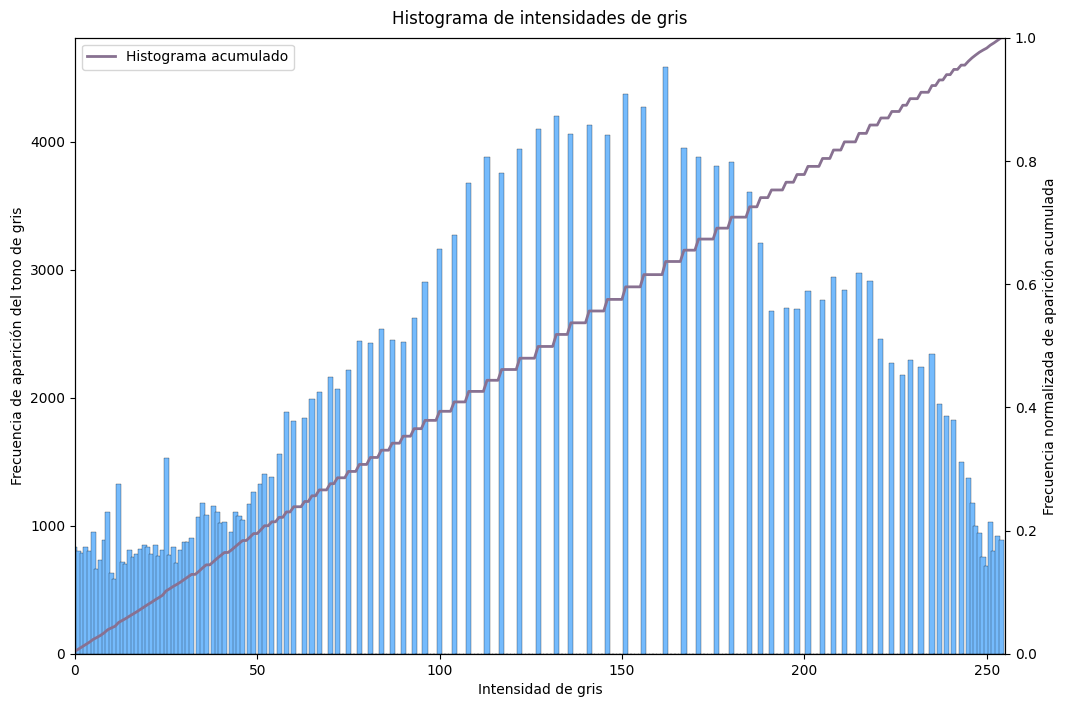

In [30]:
hist3 = histograma(img12MejoradaEc, accumulated=True)

Después de aplicar la ecualización en la imagen en escala de grises, se puede notar que se ha utilizado el rango completo de intensidades en comparación con la imagen original. Aunque el "pico" del histograma se mantiene en el mismo punto alrededor del nivel de gris 170, se puede observar una distribución más uniforme de las intensidades. Además, el histograma acumulado tiende hacia una recta, lo que indica una ecualización adecuada y una distribución uniforme de intensidades en toda la imagen. En resumen, estos resultados demuestran la efectividad de la técnica de ecualización aplicada en la imagen en cuestión.

## Detección de bordes
La detección de bordes es una técnica de procesamiento de imágenes que se utiliza para encontrar los bordes o límites entre las diferentes regiones en una imagen. Los bordes se pueden definir como transiciones bruscas de intensidad de píxel, que se utilizan para identificar cambios en la textura, la forma y la estructura de la imagen.

Existen varios algoritmos para la detección de bordes, pero en este caso, explicaremos las diferencias entre los métodos de Sobel, Prewitt y Canny:

- Filtro Sobel: El filtro Sobel es un operador de convolución que utiliza dos máscaras de convolución separables para calcular las derivadas de primer orden en dirección horizontal y vertical de una imagen. La magnitud del gradiente se calcula a partir de la raíz cuadrada de la suma de los cuadrados de las derivadas horizontal y vertical. El filtro Sobel es rápido y eficiente, pero puede producir bordes gruesos e imprecisos.

- Filtro Prewitt: El filtro Prewitt es similar al filtro Sobel, pero utiliza máscaras de convolución de 3x3 para calcular las derivadas de primer orden en dirección horizontal y vertical. La magnitud del gradiente se calcula de la misma manera que en el filtro Sobel. Aunque los filtros de Prewitt son menos sensibles al ruido que los filtros de Sobel, también tienen menos precisión.

- Algoritmo de Canny: El algoritmo de Canny es un método más avanzado para la detección de bordes. Utiliza una combinación de filtros Gaussianos para suavizar la imagen, seguido de la detección de bordes con el operador de Sobel o Prewitt. A continuación, se aplica un umbral doble para eliminar los bordes no deseados y reducir el ruido en la imagen. El algoritmo de Canny produce bordes finos y precisos, pero es más lento y complejo que los filtros Sobel y Prewitt.

En resumen, los filtros Sobel y Prewitt son métodos más simples y rápidos para la detección de bordes, mientras que el algoritmo de Canny es más avanzado y preciso pero requiere más tiempo y esfuerzo de procesamiento.

Se compararán los distintos algoritmos de detección de bordes mencionados. Para esto, se definirán las funciones `sobel`, `canny` y `prewitt`, además de la función `convolucion2D` que es la que se encarga de realizar la convolución de la imagen con el kernel.

In [31]:
def convolucion2D(img: np.ndarray, kernel:np.ndarray) -> np.ndarray:
    '''
    Función que realiza la convolución 2D entre una imagen y un kernel gaussiano o promediador
    Parámetros: 
        img: imagen de entrada
        kernel: kernel de convolución
    ''' 
    nPad = int((kernel.shape[0]-1)/2)

    #crear imagen de salida
    imgFilt = np.zeros((img.shape[0], img.shape[1]))

    #crear copia de la imagen de original y paddearla
    imgCopy = np.copy(img)
    imgCopy = zeroPadding(imgCopy, nPad)

    #recorrer la imagen
    for f in range(nPad, nPad + img.shape[0]): 
        for c in range(nPad, nPad + img.shape[1]):
            #recorrer el kernel
            for i in range(kernel.shape[0]):
                for j in range(kernel.shape[1]):
                    #multiplicar el valor del kernel por el valor de la imagen
                    imgFilt[f-nPad, c-nPad] += kernel[i,j] * imgCopy[f-nPad+i, c-nPad+j]
    
    '''
        Explicacion del bloque de for:
        f y c recorren la imagen original
        i y j recorren el kernel
        f-nPad+i y c-nPad+j recorren la imagen copia, donde el -nPad es para que no se salga de los limites
        de la imagen copia, y el +i y +j es para que se mueva junto con el kernel

        En principio, imgFilt esta llena de ceros, por lo que al sumarle el valor de la imagen copia iteracion
        a iteracion, eventualmente se logra darle el efecto de promedio o gaussiano porque se acumulan las 
        distintas multiplicaciones de la imagen copia con el kernel
    '''
    
    return imgFilt


In [32]:
def sobel(img: np.ndarray) -> np.ndarray :
    '''
        Función que realiza el filtro de Sobel a una imagen
        Parámetros: 
            img: imagen de entrada
            
        Devuelve:
            gradX, gradY: gradientes en x e y de la imagen
    ''' 
    #kernel para el filtro de Sobel
    sobelH = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    sobelV = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    
    #aplicar el filtro de Sobel
    gradX = convolucion2D(img, sobelH)
    gradY = convolucion2D(img, sobelV)
    
    return gradX, gradY

In [33]:
def canny(img:np.ndarray, h1:int, h2:int) -> np.ndarray :  
    '''
        Función que realiza el filtro de Canny a una imagen para detectar bordes
        Parámetros:
        img : imagen de entrada (gris)
        h1 : umbral inferior
        h2 : umbral superior
        
        Devuelve:
        Imagen con bordes detectados
    '''  
    # Calculo de gradientes con Sobel
    gradX, gradY = sobel(img)
    
    moduloGrad = np.sqrt(gradX**2 + gradY**2) # calculo de modulo de los gradientes
    moduloGrad = moduloGrad / moduloGrad.max() * 255 # nivel maximo seteado en 255.
    angleGrad = np.arctan2(gradY, gradX) # calculo de angulos de los gradientes (ESTA EN RAD)
    angleGrad = np.rad2deg(angleGrad) # conversion a grados
    
    suppressed = np.zeros_like(moduloGrad)
    # si los angulos son negativos, se suman 180 grados para que queden en el semiplano positivo
    angleGrad[angleGrad < 0] += 180 
    # si los angulos son positivos, se les resta 180 grados para que queden en el semiplano positivo
    angleGrad[angleGrad >= 180] -= 180 
    
    angleAux = np.zeros_like(angleGrad)

    for i in range(1, moduloGrad.shape[0]-1):
        for j in range(1, moduloGrad.shape[1]-1):
            if (0 <= angleGrad[i, j] < 22.5) or (157.5 < angleGrad[i, j] <= 180):
                angleAux[i, j] = 0
                if (moduloGrad[i, j] >= moduloGrad[i + 1, j]) and (moduloGrad[i, j] >= moduloGrad[i - 1, j]):
                    suppressed[i, j] = moduloGrad[i, j]
                else:
                    suppressed[i, j] = 0
            elif 22.5 <= angleGrad[i, j] < 67.5:
                angleAux[i, j] = 45
                if (moduloGrad[i, j] >= moduloGrad[i + 1, j - 1]) and (moduloGrad[i, j] >= moduloGrad[i - 1, j + 1]):
                    suppressed[i, j] = moduloGrad[i, j]
                else:
                    suppressed[i, j] = 0
            elif 67.5 <= angleGrad[i, j] < 112.5:
                angleAux[i, j] = 90
                if (moduloGrad[i, j] >= moduloGrad[i, j + 1]) and (moduloGrad[i, j] >= moduloGrad[i, j - 1]):
                    suppressed[i, j] = moduloGrad[i, j]
                else:
                    suppressed[i, j] = 0
            elif 112.5 <= angleGrad[i, j] < 157.5:
                angleAux[i, j] = 135
                if (moduloGrad[i, j] >= moduloGrad[i + 1, j + 1]) and (moduloGrad[i, j] >= moduloGrad[i - 1, j - 1]):
                    suppressed[i, j] = moduloGrad[i, j]
                else:
                    suppressed[i, j] = 0
     
     
    strong_i, strong_j = np.where(suppressed >= h2)
    weak_i, weak_j = np.where((suppressed <= h2) & (suppressed >= h1))
    
    suppressed[strong_i, strong_j] = h2
    suppressed[weak_i, weak_j] = h1
    
    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            if (img[i, j] ==  h1):
                try:
                    if ((img[i + 1, j - 1] == h2) or (suppressed[i + 1, j] == h2) or (suppressed[i + 1, j + 1] == h2)
                            or (suppressed[i, j - 1] == h2) or (suppressed[i, j + 1] == h2)
                            or (suppressed[i - 1, j - 1] == h2) or (suppressed[i - 1, j] == h2) or (
                                    suppressed[i - 1, j + 1] == h2)):
                        suppressed[i, j] = h2
                    else:
                        suppressed[i, j] = 0
                except IndexError as e:
                    pass
    return suppressed

In [34]:
def prewitt(img: np.ndarray):
    '''
    Función que realiza el filtro de Sobel a una imagen
    Parámetros: 
        img: imagen de entrada
        
    Devuelve:
        gradX, gradY: gradientes en x e y de la imagen
    ''' 
    
    #kernels de Prewitt
    prewittV = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    prewittH = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    
    gradX = convolucion2D(img, prewittH)
    gradY = convolucion2D(img, prewittV)
    
    return gradX, gradY
    

In [39]:
# BORDES CON CANNY
h1 = 90
h2 = 125
## sin filtrar
imgBordesCanny = canny(img12MejoradaEc, h1, h2)
kernelGaussiano =  np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
img12MejoradaEcfiltrada = convolucion2D(img12MejoradaEc, kernelGaussiano)
imgBordesCannyFiltrada = canny(img12MejoradaEcfiltrada, h1, h2)

# BORDES CON SOBEL
gradX, gradY = sobel(img12MejoradaEc)
imgBordesSobel = np.sqrt(gradX**2 + gradY**2)

# BORDES CON PREWITT
gradX, gradY = prewitt(img12MejoradaEc)
imgBordesPrewitt = np.sqrt(gradX**2 + gradY**2)

Vamos a ver que algoritmo para detectar bordes es mejor para el caso en analisis. Para esto, se compararán los bordes detectados por el filtro de Sobel, Prewitt y los detectados por el filtro de Canny en 2 situaciones distintas: procesada con los pasos anteriores y otro intento con los pasos de procesamiento anteriores más un filtro con kernel gaussiano.

Es importante mencionar que aunque se muestra el algoritmo de Canny para un solo conjunto de umbrales, se probó con diferentes combinaciones de umbrales y se iteró hasta obtener el mejor resultado visual posible.

Para futuras mejoras, se podría modificar la función para que en lugar de tomar los valores h1 y h2 como parámetros, tome un valor sigma y calcule los umbrales automáticamente en función de este parámetro y de la mediana o media de las intensidades de la imagen, tal como se ha visto en otras implementaciones disponibles en línea.

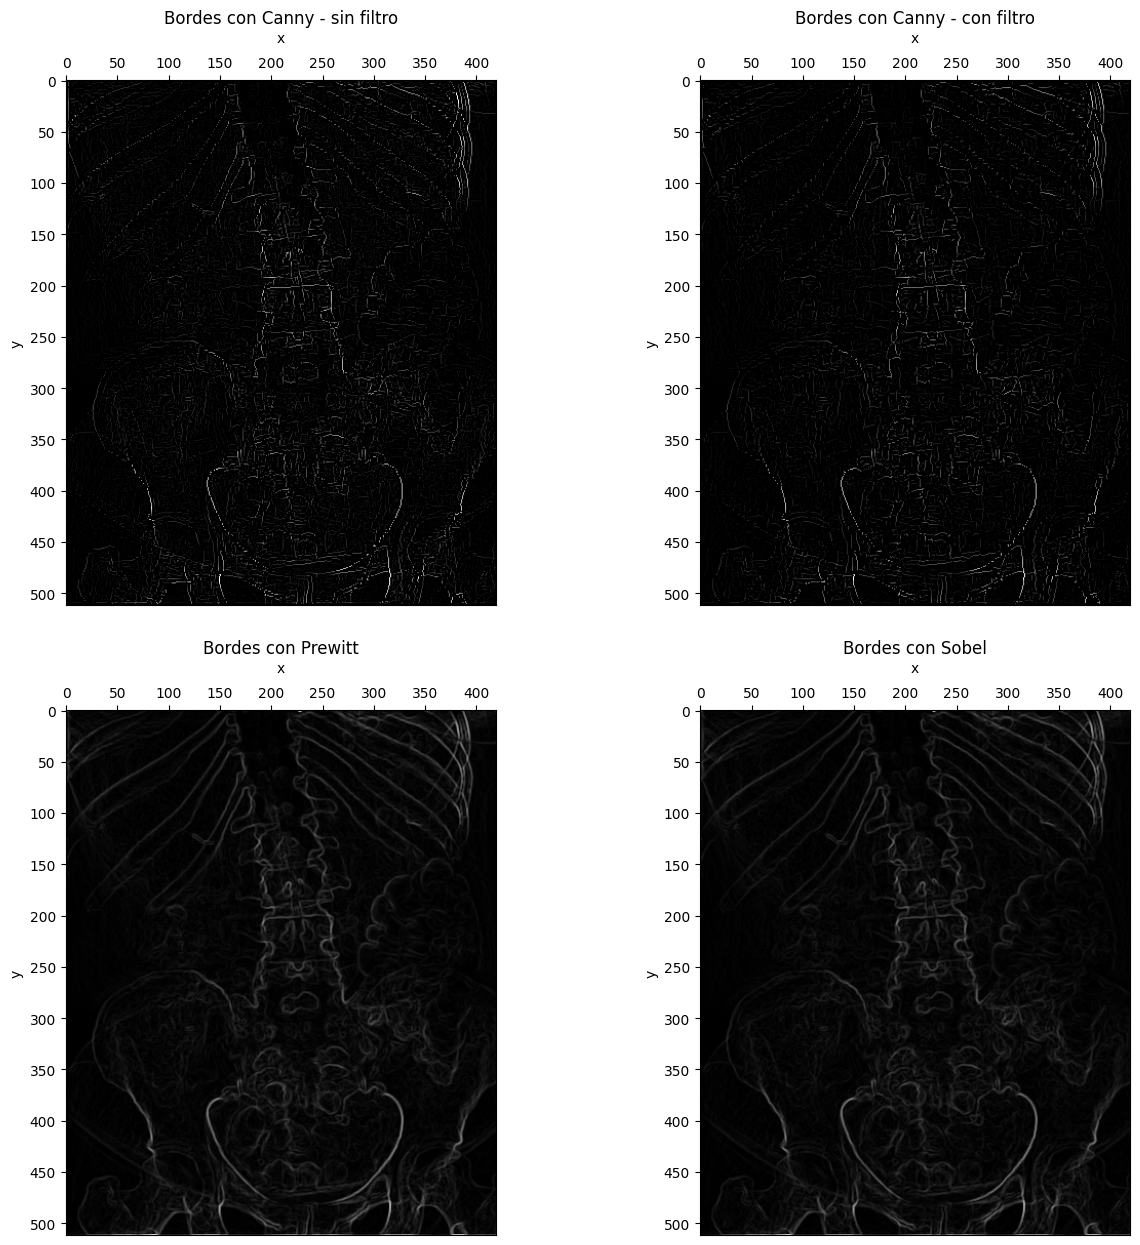

In [40]:

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0, 0].imshow(imgBordesCanny, cmap='gray')
ax[0, 0].set_title('Bordes con Canny - sin filtro')
ax[0,0].set_xlabel('x')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].xaxis.labelpad = 10
ax[0,0].xaxis.set_ticks_position('top')
ax[0,0].set_ylabel('y')
ax[0,0].set_yticks(np.arange(0, y, 50))


ax[0,1].imshow(imgBordesCannyFiltrada, cmap='gray')
ax[0,1].set_title('Bordes con Canny - con filtro')
ax[0,1].set_xlabel('x')
ax[0,1].xaxis.set_label_position('top')
ax[0,1].xaxis.labelpad = 10
ax[0,1].xaxis.set_ticks_position('top')
ax[0,1].set_ylabel('y')
ax[0,1].set_yticks(np.arange(0, y, 50))

ax[1,1].imshow(imgBordesSobel, cmap='gray')
ax[1,1].set_title('Bordes con Sobel')
ax[1,1].set_xlabel('x')
ax[1,1].xaxis.set_label_position('top')
ax[1,1].xaxis.labelpad = 10
ax[1,1].xaxis.set_ticks_position('top')
ax[1,1].set_ylabel('y')
ax[1,1].set_yticks(np.arange(0, y, 50))

ax[1,0].imshow(imgBordesPrewitt, cmap='gray')
ax[1,0].set_title('Bordes con Prewitt')
ax[1,0].set_xlabel('x')
ax[1,0].xaxis.set_label_position('top')
ax[1,0].xaxis.labelpad = 10
ax[1,0].xaxis.set_ticks_position('top')
ax[1,0].set_ylabel('y')
ax[1,0].set_yticks(np.arange(0, y, 50))

plt.show()
